In [0]:
#set up the spark env on colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install pyspark
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()

     |████████████████████████████████| 217.8MB 59kB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=85d2960740f67f77db7349d08f45db660569d49f5e791070fac6fdf2a0bbb422
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pyspark import SparkConf, SparkContext
import sys
import re, string 
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('correlate_logs').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [0]:
admission = spark.read.csv("./drive/My Drive/mimic3/ADMISSIONS.csv.gz", header=True)
patients = spark.read.csv("./drive/My Drive/mimic3/PATIENTS.csv.gz", header=True)
transfers = spark.read.csv("./drive/My Drive/mimic3/TRANSFERS.csv.gz", header=True)
callout = spark.read.csv("./drive/My Drive/mimic3/CALLOUT.csv.gz", header=True)
diagonosis = spark.read.csv("./drive/My Drive/mimic3/DIAGNOSES_ICD.csv.gz", header=True)
procedures = spark.read.csv("./drive/My Drive/mimic3/PROCEDURES_ICD.csv.gz", header=True)
cptevent = spark.read.csv("./drive/My Drive/mimic3/CPTEVENTS.csv.gz", header=True)
inputevents_cv = spark.read.csv("./drive/My Drive/mimic3/INPUTEVENTS_CV.csv.gz", header=True)
inputevents_mv = spark.read.csv("./drive/My Drive/mimic3/INPUTEVENTS_MV.csv.gz", header=True)
outputevents = spark.read.csv("./drive/My Drive/mimic3/OUTPUTEVENTS.csv.gz", header=True)
labs = spark.read.csv("./drive/My Drive/mimic3/LABEVENTS.csv.gz", header=True)
microlabs = spark.read.csv("./drive/My Drive/mimic3/MICROBIOLOGYEVENTS.csv.gz", header=True)
notes = spark.read.csv("./drive/My Drive/mimic3/NOTEEVENTS.csv.gz", header=True)
proceduresevent = spark.read.csv("./drive/My Drive/mimic3/PROCEDUREEVENTS_MV.csv.gz", header=True)
chartevents = spark.read.csv("./drive/My Drive/mimic3/CHARTEVENTS.csv.gz", header=True)
prescriptions = spark.read.csv("./drive/My Drive/mimic3/PRESCRIPTIONS.csv.gz", header=True)
D_procdedures = spark.read.csv("./drive/My Drive/mimic3/D_ICD_PROCEDURES.csv.gz", header=True)

In [0]:
#Add the Length of Stay feature
admission = admission.withColumn('ADMITTIME',admission['ADMITTIME'].cast(types.TimestampType())).withColumn('DISCHTIME',admission['DISCHTIME'].cast(types.TimestampType()))
admission = admission.withColumn('LOSdays',admission['DISCHTIME'].cast(types.LongType())-admission['ADMITTIME'].cast(types.LongType()))
admission = admission.withColumn('LOSdays', functions.round(admission['LOSdays']/(3600*24),2))

In [0]:
#Calculate the patient age by using the first transfer record and DOB feature 
first_transfer = transfers.groupBy('SUBJECT_ID').agg({'INTIME':'min'})
joined_df = first_transfer.join(patients, first_transfer['SUBJECT_ID']==patients['SUBJECT_ID'], 'inner')
joined_df = joined_df.withColumn('DOB',joined_df['DOB'].cast(types.TimestampType())).withColumn('min(INTIME)',joined_df['min(INTIME)'].cast(types.TimestampType()))
# joined_df = joined_df.groupBy(patients['SUBJECT_ID']).agg({"INTIME": "min"})

In [0]:
joined_df = joined_df.withColumn('Age',joined_df['min(INTIME)'].cast(types.LongType())-joined_df['DOB'].cast(types.LongType()))
joined_df = joined_df.withColumn('Age',functions.round(joined_df['Age']/(365.242*3600*24),4))
joined_df = joined_df.select(first_transfer.SUBJECT_ID,'Age','Gender') 
admission = admission.join(joined_df, admission['SUBJECT_ID']==joined_df['SUBJECT_ID'],'left').drop(joined_df.SUBJECT_ID)
admission = admission.withColumnRenamed('DIAGNOSIS','AdmitDiagnosis')

In [0]:
# Calculate the daily callout for each admission 
callout_count = callout.groupBy('HADM_ID').agg({'CALLOUT_SERVICE':'count'})
admission = admission.join(callout_count, callout_count['HADM_ID']==admission['HADM_ID'], 'left').drop(callout_count.HADM_ID)
admission = admission.withColumn('NumCallouts', functions.round(admission['count(CALLOUT_SERVICE)']/admission['LOSdays'],2))

In [0]:
# Calculate the daily diagonosis for each admission 
diagonosis_count = diagonosis.groupBy('HADM_ID').agg({'ICD9_CODE':'count'})
admission = admission.join(diagonosis_count, diagonosis_count['HADM_ID']==admission['HADM_ID'], 'left').drop(diagonosis_count.HADM_ID)
admission = admission.withColumn('NumDiagnosis', functions.round(admission['count(ICD9_CODE)']/admission['LOSdays'],2))

In [0]:
# Calculate the daily procedure for each admission 
procedures_count = procedures.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(procedures_count, procedures_count['HADM_ID']==admission['HADM_ID'], 'left').drop(procedures_count.HADM_ID)
admission = admission.withColumn('NumProcs', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
# replace all null with 0 
admission = admission.na.fill(0)
admission = admission.drop('count(CALLOUT_SERVICE)', 'count(ICD9_CODE)', 'count(HADM_ID)')

In [0]:
# Calculate the daily CPTevents for each admission 
cptevent_count = cptevent.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(cptevent_count, cptevent_count['HADM_ID']==admission['HADM_ID'], 'left').drop(cptevent_count.HADM_ID)
admission = admission.withColumn('NumCPTevents', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')

In [0]:
# Caculate daily average number of input events(union of cv events and mv events)
inputevents_cv_count = inputevents_cv.groupby('HADM_ID').agg({'HADM_ID':'count'})
inputevents_mv_count = inputevents_mv.groupby('HADM_ID').agg({'SUBJECT_ID':'count'})
admission = admission.join(inputevents_cv_count, inputevents_cv_count['HADM_ID']==admission['HADM_ID'], 'left').drop(inputevents_cv_count.HADM_ID)
admission = admission.join(inputevents_mv_count, inputevents_mv_count['HADM_ID']==admission['HADM_ID'], 'left').drop(inputevents_mv_count.HADM_ID)
admission = admission.na.fill(0)
admission = admission.withColumn('NumInput', functions.round((admission['count(HADM_ID)']+admission['count(SUBJECT_ID)'])/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)', 'count(SUBJECT_ID)')                                                                                                                



In [0]:
# Caculate daily average number of output events
outputevents_count = outputevents.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(outputevents_count, outputevents_count['HADM_ID']==admission['HADM_ID'], 'left').drop(outputevents_count.HADM_ID)
admission = admission.withColumn('NumOutput', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate daily average number of labs
labs_count = labs.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(labs_count, labs_count['HADM_ID']==admission['HADM_ID'], 'left').drop(labs_count.HADM_ID)
admission = admission.withColumn('NumLabs', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate daily average number of microbiology labs
microlabs_count = microlabs.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(microlabs_count, microlabs_count['HADM_ID']==admission['HADM_ID'], 'left').drop(microlabs_count.HADM_ID)
admission = admission.withColumn('NumMicroLabs', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate Daily average number of notes 
notes_count = notes.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(notes_count, notes_count['HADM_ID']==admission['HADM_ID'], 'left').drop(notes_count.HADM_ID)
admission = admission.withColumn('NumNotes', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate Daily average number of procedure events 
proceduresevent_count = proceduresevent.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(proceduresevent_count, proceduresevent_count['HADM_ID']==admission['HADM_ID'], 'left').drop(proceduresevent_count.HADM_ID)
admission = admission.withColumn('NumProcEvents', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate Daily average number of procedure events 
transfers_count = transfers.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(transfers_count, transfers_count['HADM_ID']==admission['HADM_ID'], 'left').drop(transfers_count.HADM_ID)
admission = admission.withColumn('NumTransfers', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate Daily average number of chart events 
chartevents_count = chartevents.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(chartevents_count, chartevents_count['HADM_ID']==admission['HADM_ID'], 'left').drop(chartevents_count.HADM_ID)
admission = admission.withColumn('NumChartEvents', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)

In [0]:
# Caculate Daily average number of prescription
prescriptions_count = prescriptions.groupBy('HADM_ID').agg({'HADM_ID':'count'})
admission = admission.join(prescriptions_count, prescriptions_count['HADM_ID']==admission['HADM_ID'], 'left').drop(prescriptions_count.HADM_ID)
admission = admission.withColumn('NumRx', functions.round(admission['count(HADM_ID)']/admission['LOSdays'],2))
admission = admission.drop('count(HADM_ID)')
admission = admission.na.fill(0)


In [0]:
# Extract the first procedure that paitient took after admission 
first_procedure = procedures.groupBy('HADM_ID').agg({'SEQ_NUM':'min'})
first_procedure = first_procedure.join(procedures,first_procedure['HADM_ID']==procedures['HADM_ID'],'inner').drop(first_procedure.HADM_ID)
first_procedure = first_procedure.filter(first_procedure['min(SEQ_NUM)']==first_procedure['SEQ_NUM'])
first_procedure = first_procedure.join(D_procdedures, first_procedure['ICD9_CODE']==D_procdedures['ICD9_CODE']).drop(D_procdedures.ICD9_CODE)
first_procedure = first_procedure.drop('min(SEQ_NUM)', 'ROW_ID', 'SUBJECT_ID' ,'SEQ_NUM', 'ICD9_CODE', 'LONG_TITLE')
admission = admission.join(first_procedure, first_procedure['HADM_ID']==admission['HADM_ID'], 'left').drop(first_procedure.HADM_ID)

In [0]:
# Calculate the total number of daily interactions between the patient and the hospital (a summary of all the above)
admission = admission.withColumn('TotalNumInteract',admission['NumChartEvents']+admission['NumTransfers']+admission['NumProcEvents']+admission['NumRx']\
                                 +admission['NumOutput']+admission['NumNotes']+admission['NumMicroLabs']+admission['NumLabs']+admission['NumInput']\
                                 +admission['NumCPTevents']+admission['NumProcs']+admission['NumDiagnosis']+admission['NumCallouts'])
# Drop the trvial columns 
admission = admission.drop('ROW_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DISCHARGE_LOCATION', 'LANGUAGE', 'EDREGTIME', 'EDOUTTIME', 'HAS_CHARTEVENTS_DATA')
# Rename some columns for future efficiency
admission = admission.withColumnRenamed('ADMISSION_TYPE','admit_type').withColumnRenamed('ADMISSION_LOCATION', 'admit_location').withColumnRenamed('INSURANCE', 'insurance').withColumnRenamed('RELIGION', 'religion').withColumnRenamed('Age', 'age').withColumnRenamed('Gender', 'gender').withColumnRenamed('ETHNICITY', 'ethnicity').withColumnRenamed('MARITAL_STATUS' ,'marital_status').withColumnRenamed('HOSPITAL_EXPIRE_FLAG', 'ExpiredHospital').withColumnRenamed('SHORT_TITLE','AdmitProcedure')

In [0]:
# Save the preprocessing data as csv for modeling

# admission.repartition(1).write.option("header", "true").save("./drive/My Drive/mydata.csv")
# admission.write.csv('./drive/My Drive/mimic3/mimic3_pre.csv', header=True)
# admission.repartition(1).write.csv("'./drive/My Drive/mimic3/mimic3_pre1.csv", sep='|')
admission.coalesce(1).write.format('com.databricks.spark.csv').save('./drive/My Drive/mimic3_pre',header = 'true')

In [0]:
admission.filter((admission['AdmitDiagnosis']=='UPPER GI BLEED') & (admission['RELIGION']=='NOT SPECIFIED') & (admission['MARITAL_STATUS']=='SINGLE') & (admission['ADMISSION_TYPE']=='EMERGENCY') & \
               (admission['INSURANCE']=='Private') &  (admission['ETHNICITY']=='WHITE') & (admission['ADMISSION_LOCATION']=='EMERGENCY ROOM ADMIT') &(admission['Gender']=='M')  ).show()

In [0]:
admission.filter(admission['HADM_ID']==100003).show()

In [0]:
admission.count()

58976

In [0]:
admission.show(5)

+----------+-------+----------+--------------------+----------+-----------------+--------------+--------------------+--------------------+--------------------+-------+-------+------+-----------+------------+--------+------------+--------+---------+-------+------------+--------+-------------+------------+--------------+-----+--------------------+------------------+
|SUBJECT_ID|HADM_ID|admit_type|      admit_location| insurance|         religion|marital_status|           ethnicity|      AdmitDiagnosis|HOSPITAL_EXPIRE_FLAG|LOSdays|    age|gender|NumCallouts|NumDiagnosis|NumProcs|NumCPTevents|NumInput|NumOutput|NumLabs|NumMicroLabs|NumNotes|NumProcEvents|NumTransfers|NumChartEvents|NumRx|         SHORT_TITLE|  TotalNumInteract|
+----------+-------+----------+--------------------+----------+-----------------+--------------+--------------------+--------------------+--------------------+-------+-------+------+-----------+------------+--------+------------+--------+---------+-------+----------

In [2]:
# IMPORT modules
# Turn GPU on

import pandas as pd
import numpy as np
import random as rnd
import pprint
from itertools import cycle, islice
import numpy as np

from scipy.stats import multivariate_normal

from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
# from sklearn.utils.fixes import signature
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')
# import os
# print(os.listdir("../input"))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Manually rename the part0000....csv file to mimic3_pre.csv
data = pd.read_csv('/content/drive/My Drive/mimic3_pre/mimic3_pre.csv')
print("With id", data.shape)

data_full = data.drop(['SUBJECT_ID','HADM_ID'], 1)
print("No id",data_full.shape)

With id (58976, 28)
No id (58976, 26)


In [4]:
print(data_full.shape)
data_full.info()
data_full.describe()

(58976, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   admit_type        58976 non-null  object 
 1   admit_location    58976 non-null  object 
 2   insurance         58976 non-null  object 
 3   religion          58518 non-null  object 
 4   marital_status    48848 non-null  object 
 5   ethnicity         58976 non-null  object 
 6   AdmitDiagnosis    58951 non-null  object 
 7   ExpiredHospital   58976 non-null  int64  
 8   LOSdays           58976 non-null  float64
 9   age               58976 non-null  float64
 10  gender            58976 non-null  object 
 11  NumCallouts       58976 non-null  float64
 12  NumDiagnosis      58976 non-null  float64
 13  NumProcs          58976 non-null  float64
 14  NumCPTevents      58976 non-null  float64
 15  NumInput          58976 non-null  float64
 16  NumOutput         58976 non-

,ExpiredHospital,LOSdays,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumOutput,NumLabs,NumMicroLabs,NumNotes,NumProcEvents,NumTransfers,NumChartEvents,NumRx,TotalNumInteract
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,0.099261,10.134000,64.014589,0.098508,2.529240,0.745273,1.053509,29.575238,7.017054,44.628215,1.183752,3.628099,0.667849,1.049343,518.870360,9.198982,620.245421
std,0.299014,12.456668,57.125449,0.335281,10.029017,4.475556,2.243433,70.959695,8.433482,103.155071,4.176414,7.435385,2.953734,3.996817,772.702496,24.995591,933.335790
min,0.000000,-0.950000,0.000000,-50.000000,-850.000000,-250.000000,-150.000000,-5800.000000,-500.000000,-6200.000000,-200.000000,-400.000000,-416.670000,-200.000000,-50300.000000,-3800.000000,-60933.350000
25%,0.000000,3.740000,42.908700,0.000000,0.820000,0.210000,0.000000,4.830000,1.747500,26.920000,0.160000,1.300000,0.000000,0.380000,206.967500,4.320000,268.755000
50%,0.000000,6.470000,61.168250,0.000000,1.400000,0.420000,0.970000,13.920000,5.280000,38.390000,0.510000,2.290000,0.000000,0.650000,416.510000,8.350000,498.170000
75%,0.000000,11.800000,75.393900,0.150000,2.400000,0.710000,1.550000,34.220000,10.440000,50.670000,1.350000,4.350000,0.880000,1.050000,697.255000,12.220000,810.895000
max,1.000000,294.660000,306.412700,50.000000,600.000000,400.000000,200.000000,4550.000000,350.000000,8800.000000,340.000000,600.000000,175.000000,300.000000,52000.000000,850.000000,64700.000000


In [5]:
# We notice that there are negative values exist from the describe table 
# This is caused by the negative LOS values 
# Calculate the percentage of negative LOS values(dead case) of the total dead cases
(data[(data['LOSdays']<0) & (data['ExpiredHospital']==1)].shape[0])/(data[data['ExpiredHospital']==1].shape[0])

0.013324222753672703

In [0]:
# As the negative LOS cases didn't take a great part of dead cases, we can drop them
data_full = data_full[data_full['LOSdays']>=0]

In [7]:
data_full.head(10)

,admit_type,admit_location,insurance,religion,marital_status,ethnicity,AdmitDiagnosis,ExpiredHospital,LOSdays,age,gender,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumOutput,NumLabs,NumMicroLabs,NumNotes,NumProcEvents,NumTransfers,NumChartEvents,NumRx,AdmitProcedure,TotalNumInteract
0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,EPISCOPALIAN,MARRIED,WHITE,RENAL MASS LEFT/SDA,0,4.40,54.5201,F,0.23,1.14,0.68,1.82,6.59,7.95,30.45,0.00,0.45,1.14,0.91,446.59,9.09,Nephroureterectomy,507.04
1,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,SUBGLOTTIC STENOSIS\LARYNGOSCOPY; MICRO WITH C...,0,0.73,24.8868,F,0.00,5.48,5.48,1.37,26.03,5.48,16.44,0.00,6.85,0.00,2.74,939.73,23.29,Destruct larynx les NEC,1032.89
2,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicaid,NOT SPECIFIED,DIVORCED,WHITE,HYPOTENSION;ALTERED MENTAL STATUS,0,15.73,45.5798,F,0.06,1.40,0.25,1.59,14.11,3.56,31.85,1.21,1.02,0.95,0.19,331.79,11.19,Cl reduc disloc-hip,399.17
3,EMERGENCY,CLINIC REFERRAL/PREMATURE,Government,PROTESTANT QUAKER,SINGLE,WHITE,RENAL FAILURE;PNEUMONIA,0,5.76,47.1602,M,0.35,3.65,0.52,2.43,45.49,9.03,64.58,1.74,2.26,2.26,0.69,685.42,15.28,Cont inv mec ven <96 hrs,833.70
4,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,JEWISH,MARRIED,WHITE,UPPER BI BLED/SDA,0,8.28,85.9865,M,0.12,1.93,0.60,0.85,6.64,5.19,25.85,0.12,0.36,0.72,0.72,264.01,8.57,Part gastrec w jej anast,315.68
5,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,CATHOLIC,MARRIED,WHITE,VISCERAL ARTERY ANEURYSM/SDA,0,5.25,74.3894,M,0.00,1.71,0.19,0.57,10.10,5.71,51.24,2.48,1.14,1.52,0.76,301.90,11.81,Abd artery resec w repla,389.13
6,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,PROTESTANT QUAKER,NaN,WHITE,NEWBORN,0,1.85,0.0021,F,0.00,2.16,0.54,0.00,0.00,0.00,14.05,0.54,1.08,0.00,2.16,17.84,0.00,Vaccination NEC,38.37
7,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,JEWISH,NaN,WHITE,NEWBORN,0,2.27,0.0006,M,0.00,1.32,0.44,0.00,0.00,0.00,13.66,0.44,0.88,0.00,1.76,18.50,0.00,Vaccination NEC,37.00
8,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,NOT SPECIFIED,SINGLE,WHITE,RIGHT LUNG CA/SDA,0,13.08,62.7394,M,0.08,1.22,0.84,0.46,26.76,4.82,31.96,0.46,2.06,0.00,0.38,267.97,7.49,NaN,344.50
9,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,PROTESTANT QUAKER,MARRIED,WHITE,PNEUMONIA,0,4.62,34.8096,F,0.22,2.38,0.22,1.30,8.44,1.73,36.15,5.63,1.30,1.95,1.73,411.04,14.72,Arterial catheterization,486.81


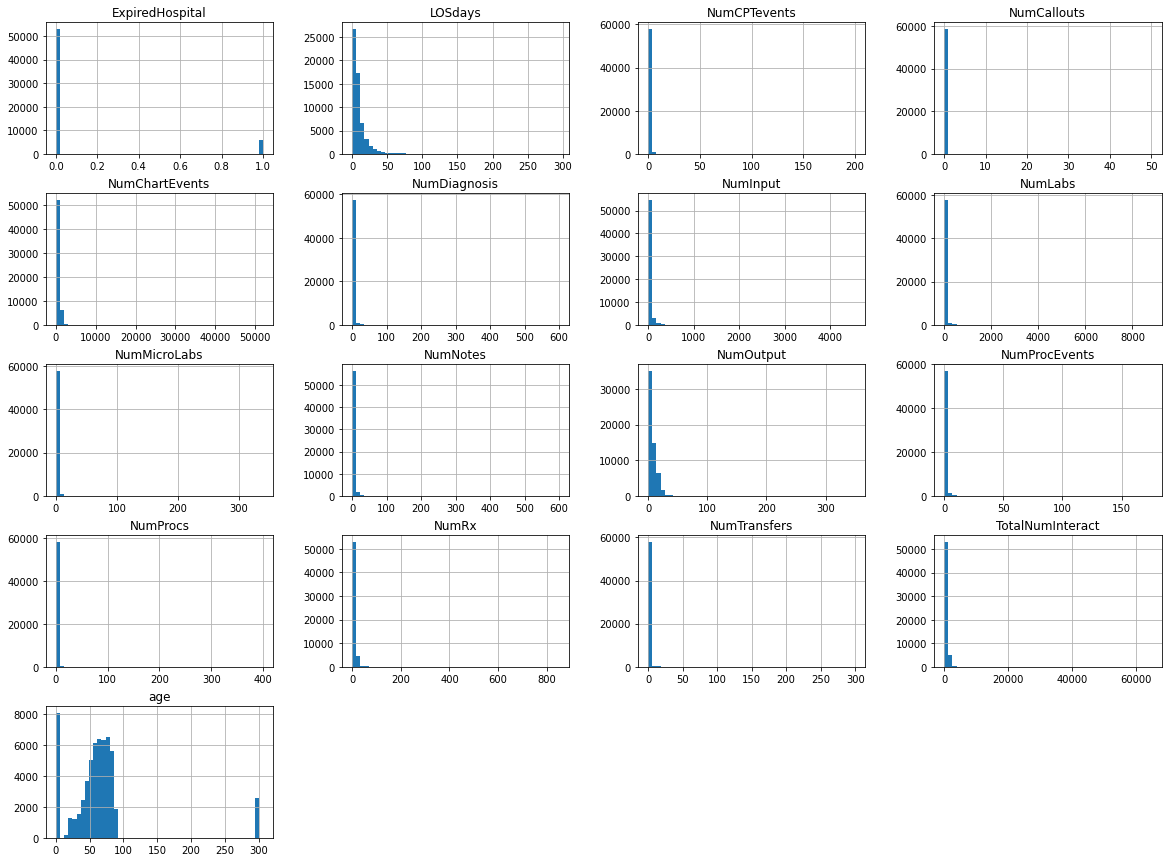

In [0]:
data_full.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# From the age histograms we saw that there are ages beyond 300
# By checking the mimic 3 reference, all ages > 89 in the database were replaced with 300
# So we replace age>300 with 89
data_full['age'] = np.where(data_full['age'] > 300, 89, data_full['age'])


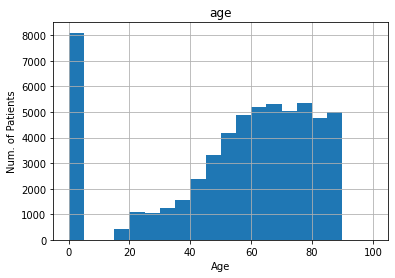

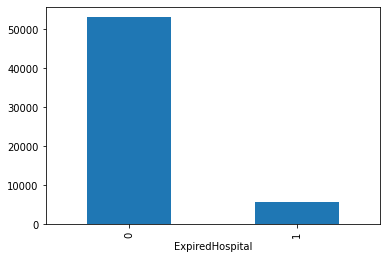

In [9]:
age_histogram = data_full.hist(column='age', bins=20, range=[0, 100])
for ax in age_histogram.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("Num. of Patients")
plt.show()
data_full.groupby('ExpiredHospital').size().plot.bar()
plt.show()

This is considered an imbalanced dataset as the classes of lived vs. expired are imbalanced 9:1. Consider a simple, dumb model, one that always predicts that the patient lives and it assumes 0 percent mortality.

Accuracy is defined as (true positives + true negatives) / all samples, so this model has a fantastic accuracy of 90 percent on MIMIC3 dataset. With 100 patients and a model predicting that all patients lived, TN=90 and FN=10, the accuracy is (0+90)/100=90 percent.


This exercise with a dumb model provides the necessary perspective on the problem, as it gives us a certain baseline to compare against the machine. We know by now that a 90 percent accuracy is not such a high goal to achieve. It’s considered common sense in ML to try come up with a sanity check, a baseline against which to compare a metric, before we measure the machine performance on a task. 

When a problem involves a moderate to highly imbalanced classes situation == such as mortality in our dataset being 10 percent — accuracy is not the only metric to monitor, as it may be quite misleading. The relevance of the predictions is an important parameter as well:

Precision = TP/(TP+FN)

How many selected items were relevant? Our dumb model’s precision is 0, as no true positives (TP) have been selected (0/0+10).

Recall = TP/TP+FP

How many relevant items are selected?  Recall for this model is also 0, as nothing predicted was relevant (actually recall is indeterminate 0/0).

#https://developers.google.com/machine-learning/crash-course/classification/accuracy

In [10]:
#LOS was eliminated from the dataset as it is never a good idea to provide the model information from the future. 
#When asked to predict mortality, the LOS is not yet known, so it should not be given to the model during training. 

# Some other non-related features are also droped 
y = data_full['ExpiredHospital']
X = data_full.drop('ExpiredHospital', 1)

X = X.drop('LOSdays', 1)
X = X.drop('AdmitDiagnosis', 1)
X = X.drop('AdmitProcedure', 1)
X = X.drop('marital_status', 1)
X = X.drop('ethnicity', 1)
X = X.drop('religion', 1)
X = X.drop('insurance', 1)

print("y - Labels", y.shape)
print("X - No Label No id ", X.shape)
print(X.columns)

y - Labels (58880,)
X - No Label No id  (58880, 18)
Index(['admit_type', 'admit_location', 'age', 'gender', 'NumCallouts',
       'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumOutput',
       'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'NumRx', 'TotalNumInteract'],
      dtype='object')


In [11]:
# Check that all numerical X columns have no missing values
X.info()
X.describe()
data_full.isnull().sum(axis = 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58880 entries, 0 to 58975
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   admit_type        58880 non-null  object 
 1   admit_location    58880 non-null  object 
 2   age               58880 non-null  float64
 3   gender            58880 non-null  object 
 4   NumCallouts       58880 non-null  float64
 5   NumDiagnosis      58880 non-null  float64
 6   NumProcs          58880 non-null  float64
 7   NumCPTevents      58880 non-null  float64
 8   NumInput          58880 non-null  float64
 9   NumOutput         58880 non-null  float64
 10  NumLabs           58880 non-null  float64
 11  NumMicroLabs      58880 non-null  float64
 12  NumNotes          58880 non-null  float64
 13  NumProcEvents     58880 non-null  float64
 14  NumTransfers      58880 non-null  float64
 15  NumChartEvents    58880 non-null  float64
 16  NumRx             58880 non-null  float6

admit_type              0
admit_location          0
insurance               0
religion              452
marital_status      10097
ethnicity               0
AdmitDiagnosis         25
ExpiredHospital         0
LOSdays                 0
age                     0
gender                  0
NumCallouts             0
NumDiagnosis            0
NumProcs                0
NumCPTevents            0
NumInput                0
NumOutput               0
NumLabs                 0
NumMicroLabs            0
NumNotes                0
NumProcEvents           0
NumTransfers            0
NumChartEvents          0
NumRx                   0
AdmitProcedure       8009
TotalNumInteract        0
dtype: int64

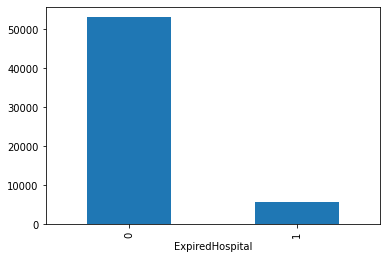

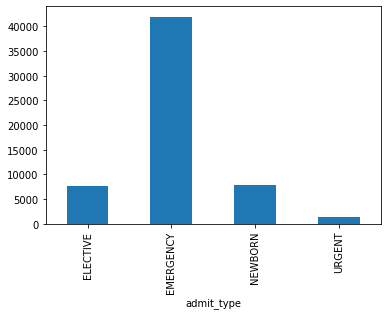

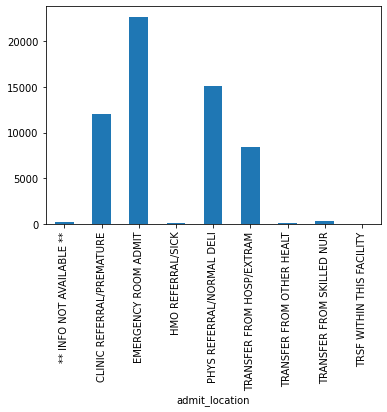

In [12]:
data_full.groupby('ExpiredHospital').size().plot.bar()
plt.show()
data_full.groupby('admit_type').size().plot.bar()
plt.show()
data_full.groupby('admit_location').size().plot.bar()
plt.show()

In [14]:
# Use one-hot-encoding to convert categorical features to numerical

print(X.shape)
categorical_columns = [
                    'gender',                     
                    'admit_type',
                    'admit_location'
                      ]
for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in X.columns:
        one_hot_encoded = pd.get_dummies(X[col])
        X = X.drop(col, axis=1)
        X = X.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
        
print(X.shape)

(58880, 30)
(58880, 30)


In [18]:
X.head()

,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumOutput,NumLabs,NumMicroLabs,NumNotes,NumProcEvents,NumTransfers,NumChartEvents,NumRx,TotalNumInteract,F,M,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM OTHER HEALT,TRANSFER FROM SKILLED NUR,TRSF WITHIN THIS FACILITY
0,54.5201,0.23,1.14,0.68,1.82,6.59,7.95,30.45,0.00,0.45,1.14,0.91,446.59,9.09,507.04,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,24.8868,0.00,5.48,5.48,1.37,26.03,5.48,16.44,0.00,6.85,0.00,2.74,939.73,23.29,1032.89,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,45.5798,0.06,1.40,0.25,1.59,14.11,3.56,31.85,1.21,1.02,0.95,0.19,331.79,11.19,399.17,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,47.1602,0.35,3.65,0.52,2.43,45.49,9.03,64.58,1.74,2.26,2.26,0.69,685.42,15.28,833.70,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
4,85.9865,0.12,1.93,0.60,0.85,6.64,5.19,25.85,0.12,0.36,0.72,0.72,264.01,8.57,315.68,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
print(data_full.shape)
print(X.shape)

XnotNorm = X.copy()
print('XnotNorm ', XnotNorm.shape)

ynotNorm = y.copy()
print('ynotNorm ', ynotNorm.shape)

(58880, 26)
(58880, 30)
XnotNorm  (58880, 30)
ynotNorm  (58880,)


In [20]:
# Normalize the data since we can see from the histgrams above, the data is skewed 
x = XnotNorm.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
XNorm = pd.DataFrame(x_scaled, columns=XnotNorm.columns)
print(XNorm)

            age  ...  TRSF WITHIN THIS FACILITY
0     -0.004857  ...                  -0.009216
1     -1.099361  ...                  -0.009216
2     -0.335066  ...                  -0.009216
3     -0.276694  ...                  -0.009216
4      1.157354  ...                  -0.009216
...         ...  ...                        ...
58875 -2.018507  ...                  -0.009216
58876 -0.798087  ...                  -0.009216
58877 -0.293983  ...                  -0.009216
58878 -2.018462  ...                  -0.009216
58879 -2.018514  ...                  -0.009216

[58880 rows x 30 columns]


In [21]:
# SPLIT into Train & Test

X_train, X_test, y_train, y_test = train_test_split(XNorm, y, test_size=0.1, random_state=42)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (52992, 30)
X_test:  (5888, 30)
y_train:  (52992,)
y_test:  (5888,)


A ML model needs one, and only one, metric to use for calculations of the loss function and optimizer. The model will refuse to work if presented with two metrics, such as precision and recall. In the case of imbalanced classes, precision and recall have one prodigy, named F1 score — the harmonic mean of precision and recall. A higher F1 score is better.

I’ve used accuracy, precision, recall and F1 score as the models’ metrics for optimization, but only one metric at a time. In addition, I’ve also optimized the models on the area under the vurve (AUC) of the receiver operating characteristic (ROC), even though ROC AUC is best used with balanced classes. A higher AUC is better.

Task: predict mortality as a supervised learning classification based on a binary decision (yes / no)
Experience: MIMIC3 subset detailed above
Performance: accuracy, F1 score, and ROC AUC 

In [0]:
# Test Models and evaluation metric
seed = 7
scorings = ['accuracy', 'f1', 'roc_auc']

# Spot Check Algorithms
Mymodels = []
Mymodels.append(('LogReg', LogisticRegression()))
Mymodels.append(('RandomForest', RandomForestClassifier()))
Mymodels.append(('SGDclassifier', SGDClassifier()))
Mymodels.append(('KNearestNeighbors', KNeighborsClassifier()))
Mymodels.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
Mymodels.append(('GaussianNB', GaussianNB()))
Mymodels.append(('SVM', SVC()))

# Evaluate each model in turn with corss validation
results = []
names = []
for scoring in scorings:
  for name, model in Mymodels:
      kfold = model_selection.KFold(n_splits=10, random_state=seed)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg) 

LogReg: 0.932631 (0.002249)
RandomForest: 0.940029 (0.002413)
SGDclassifier: 0.929216 (0.003664)
KNearestNeighbors: 0.930046 (0.002741)
DecisionTreeClassifier: 0.902080 (0.002969)
GaussianNB: 0.873792 (0.007453)
SVM: 0.933858 (0.001988)
LogReg: 0.546050 (0.015879)
RandomForest: 0.610045 (0.010186)
SGDclassifier: 0.500921 (0.038844)
KNearestNeighbors: 0.541081 (0.013481)
DecisionTreeClassifier: 0.503817 (0.016223)
GaussianNB: 0.504987 (0.017766)
SVM: 0.534952 (0.011895)
LogReg: 0.900432 (0.009283)
RandomForest: 0.925266 (0.005594)
SGDclassifier: 0.881566 (0.011689)
KNearestNeighbors: 0.830628 (0.007461)
DecisionTreeClassifier: 0.731772 (0.007912)
GaussianNB: 0.858887 (0.009837)
SVM: 0.886151 (0.006392)


In [22]:
# we can see from the above three different metrics that RF model gave the best performance 
# So in the following i will tune the hyperparameters of RF model using gird search
model = RandomForestClassifier()
param_grid = [{},]
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc') 
grid_search.fit(XNorm, y)
print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)

In [24]:

# Set the model according to above results
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    # Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

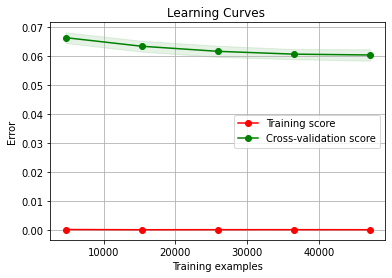

In [26]:
# LEARNING CURVES Train / Validation

title = "Learning Curves "
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, title, XNorm, y, cv=cv, n_jobs=5)

In [27]:
# Model FINAL fit and evaluation on test

model.fit(X_train, y_train)
final_predictions = model.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, final_predictions)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  5250
FP:  46
FN:  302
TP:  290
0.48986486486486486 0.8630952380952381


In [42]:
# Save the model as a pickle file so that can be used in Web application 
import pickle
import os

os.mkdir('./drive/My Drive/mortality_model.pkl')
pkl_filename = "./drive/My Drive/mortality_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

FileExistsError: ignored

In [40]:
!pwd

/content


In [0]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

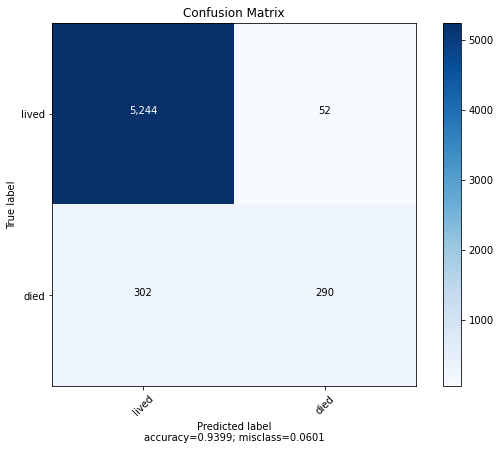

In [0]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['lived', 'died'],
                      title        = "Confusion Matrix")

In [0]:
print ('precision ',round(precision_score(y_test, final_predictions),4))
print ('recall ',round(recall_score(y_test, final_predictions) ,4))
print ('accuracy ',round(accuracy_score(y_test, final_predictions),4))
print ('F1 score ',round(f1_score(y_test, final_predictions),4))

precision  0.848
recall  0.4899
accuracy  0.9399
F1 score  0.621


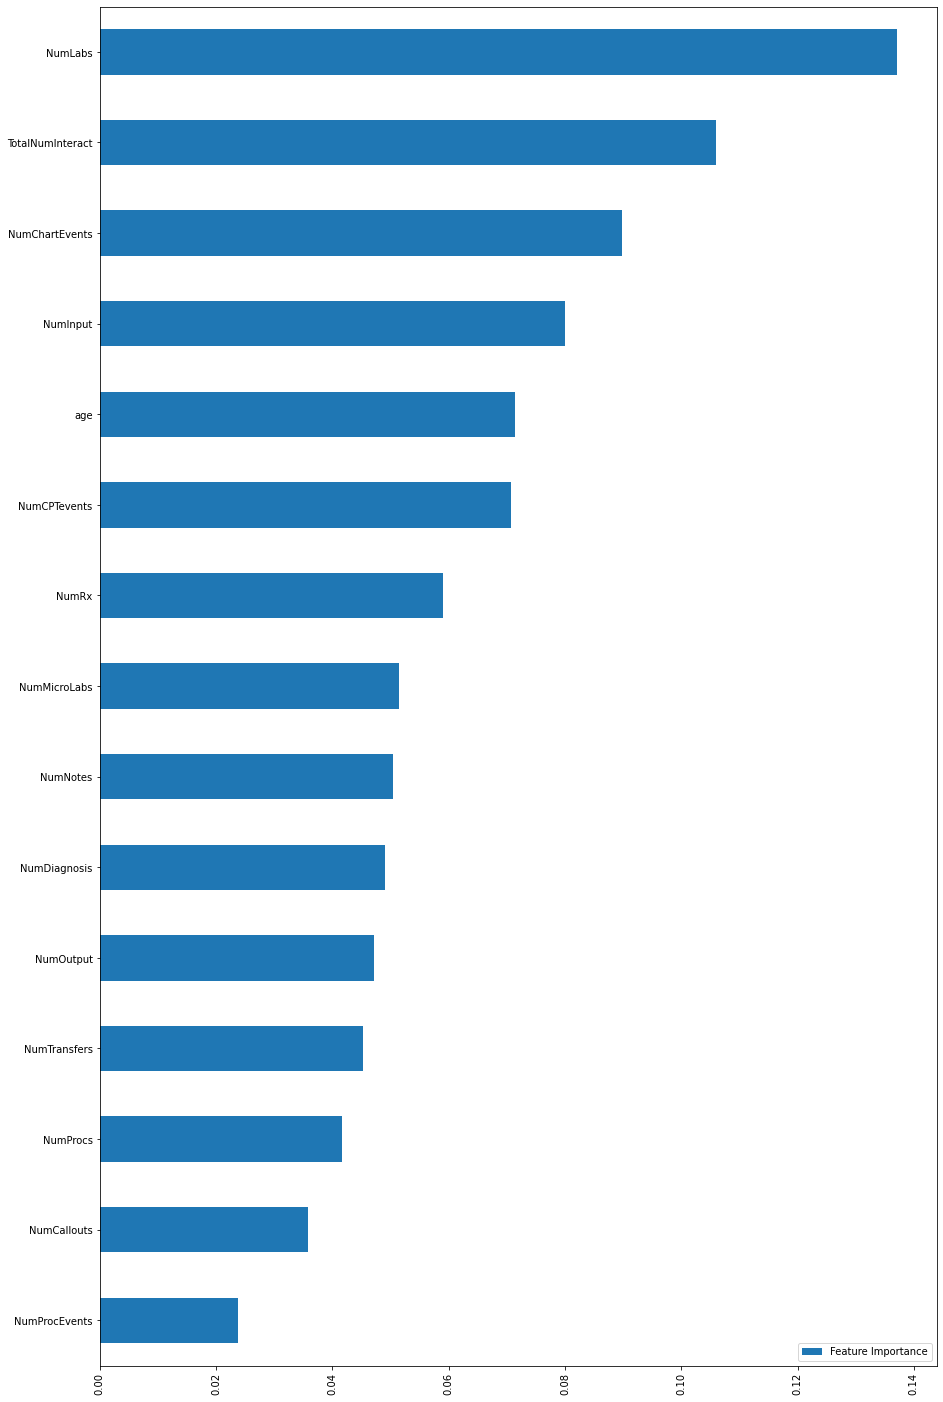

In [0]:
# FEATURE IMPORTANCE 

trainFinalFI = XNorm
yFinalFI = y
model.fit(trainFinalFI,yFinalFI)

FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model[FI_model["Feature Importance"] > 0.01].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [0]:
# List of important features for model
FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model=FI_model.sort_values('Feature Importance', ascending = False)
print(FI_model[FI_model["Feature Importance"] > 0.0025])

                           Feature Importance
NumLabs                              0.137071
TotalNumInteract                     0.105987
NumChartEvents                       0.089846
NumInput                             0.080057
age                                  0.071403
NumCPTevents                         0.070740
NumRx                                0.059056
NumMicroLabs                         0.051400
NumNotes                             0.050423
NumDiagnosis                         0.049110
NumOutput                            0.047242
NumTransfers                         0.045287
NumProcs                             0.041643
NumCallouts                          0.035810
NumProcEvents                        0.023767
EMERGENCY ROOM ADMIT                 0.005929
M                                    0.005557
F                                    0.005518
TRANSFER FROM HOSP/EXTRAM            0.004499
EMERGENCY                            0.004475
CLINIC REFERRAL/PREMATURE         

AUC: 0.740


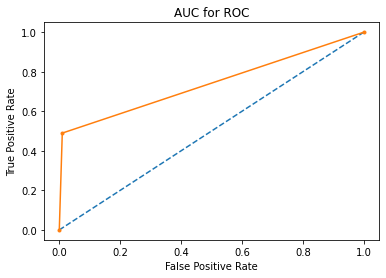

In [0]:
# calculate AUC
auc = roc_auc_score(y_test, final_predictions)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('AUC for ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
# the curve is closer to the left corner the better the model perform
# or say the larger the area under the roc curve the better the model perform 

f1=0.621


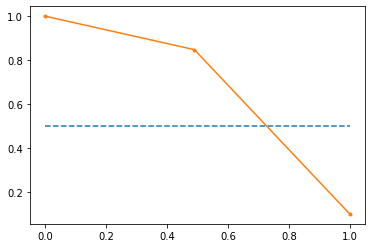

In [0]:
Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

Future work:
Tune the model with a higher recal and a reliable precision as the mortality prediction needs to be sensitive rather accurate.

In [0]:
# Try a neuronetwork model


# Use of DROPOUT to avoid over fitting
model = Sequential()
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(30,)))
#model.add(layers.BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# FIT / TRAIN model

NumEpochs = 100
BatchSize = 16

model.compile(optimizer=optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2048)              63488     
_________________________________________________________________
dense_19 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2049      
Total params: 8,458,241
Trainable params: 8,458,241
Non-trainable params: 0
____________________________________________

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

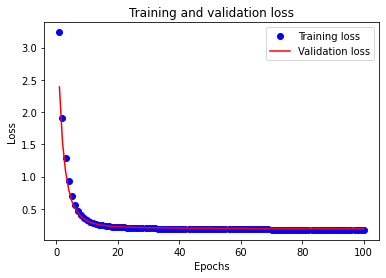

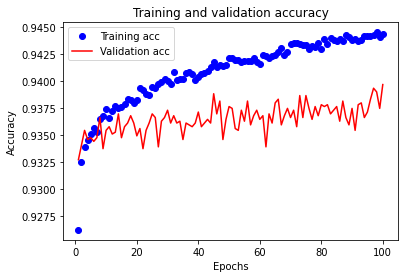

In [0]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
epochs = range(1, (len(history_dict['binary_accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
final_predictions = model.predict(X_test)

Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
#print(Preds)
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  5218
FP:  78
FN:  277
TP:  315
0.5320945945945946 0.8015267175572519


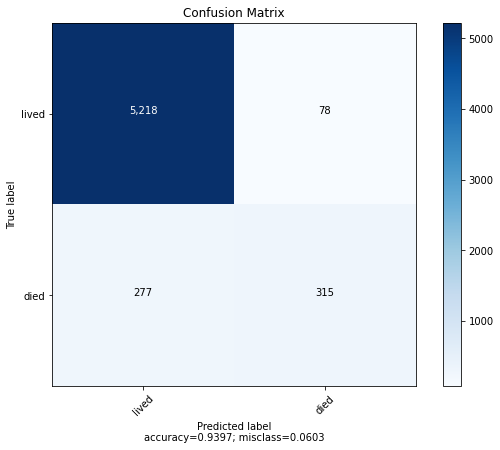

In [0]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['lived', 'died'],
                      title        = "Confusion Matrix")

In [0]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.8015267175572519
recall  0.5320945945945946
accuracy  0.9397078804347826
F1 score  0.6395939086294417


AUC: 0.759


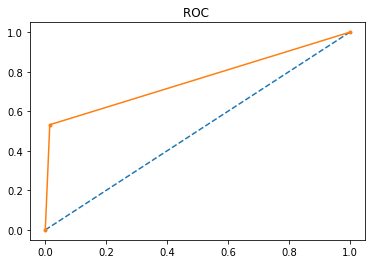

In [0]:
# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
# show the plot
plt.show()

f1=0.640 ap=0.474


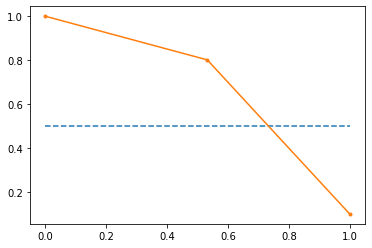

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate precision-recall AUC
#auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

In [0]:
# The NN model and RF model gave similar performances.